# Proyecto: Generación de Mapa 3D del Ecuador para Impresión 3D

---
### Enlace al Repositorio de Git: https://github.com/Fu5CHAR/Metodos_numericos_2025B_Ulloa-Francisco/tree/main/Proyecto2025B_2b 

---
## 1. Introducción

El objetivo del proyecto es proporcionar una herramienta que permita:

- Cargar y unir tiles de elevación (.hgt) para obtener un DEM del Ecuador.

- Seleccionar interactivamente una zona (lat/lon) mediante un selector (Google Maps o heatmap local).

- Procesar la elevación (suavizado, cálculo de pendientes) y generar una malla 3D.

- Construir un sólido cerrado (top+base+paredes), optimizarlo (reducción de triángulos y suavizado de malla), y exportarlo en formato STL listo para slicing (Bambu Studio).

- Mantener la escala realista del terreno, con opción de exageración vertical para mejorar legibilidad en impresiones pequeñas.

Este informe documenta tanto los principios matemáticos como la implementación práctica en Python.




## 2. Metodología

### Arquitectura del SIstema
El proyecto está organizado en dos capas principales:

1. Motor (procesamiento):

- CargarDatos.py: lectura y unión de tiles .hgt, guarda elevacion.npy y transform.txt.

- Visualizador.py: carga, recorte, cálculo de normales, creación de malla y sombreado.

- etiquetador.py (auxiliar): detección de puntos de interés dentro del cuadrante.

2. Interfaz gráfica (GUI) — carpeta GUI:

- interfazV.py: ventana principal PyQt6 + PyVista para previsualización y export.

- selector_mapa.py + mapa_google.html: selector de coordenadas basado en Google Maps.

- heatmap.py (opcional): selector local sobre un heatmap del DEM.

Flujo básico de ejecución:

1. CargarDatos.py → genera procesado/elevacion.npy y transform.txt.

2. Usuario selecciona punto (Google Maps o heatmap).

3. interfazV.VentanaTerreno toma lat/lon → convierte a indices → recorta cuadrante.

4. Se aplica suavizado y se genera la malla para previsualizar.

5. Si el usuario exporta, se ejecutan submuestreo, solid-building, decimación, suavizado de malla, escalado y guardado .stl.



### Desarrollo Matemático

1. Representación del Modelo de Elevación Digital (DEM)

- El DEM se trata como una matriz Z[i,j] donde cada celda contiene la elevación (m).

- Para pasar a coordenadas reales se usan resoluciones dx, dy (metros/píxel), calculadas a partir de la transformación afín (Affine) y la latitud para dx.

2. Suavizado Gaussiano (filtro)

- Se usa un filtro gaussiano discreto para atenuar ruido espacial y evitar aliasing antes del submuestreo.

- En el código: scipy.ndimage.gaussian_filter(z_cuadrante, sigma=1.5).

- Efecto: promediar vecinos con pesos decrecientes según la distancia; reduce picos aislados y hace la superficie más continua.

3. Derivadas y normales

- Para sombreado y estimación de pendientes se usa el operador Sobel (kernels 3×3).

- Aproximación de Zx y Zy y construcción de normales:

normal = (-dzdx, -dzdy, 1)


normal /= norm(normal)

- El producto punto de la normal con un vector de luz da el hillshade (sombreado).

4. Construcción del sólido (top + bottom + walls)

- A partir de la matriz de altura se generan puntos (x,y,z).

- Se crea una base plana en zmin - thickness y se triangulan top, bottom y paredes para obtener un volumen cerrado (build_solid_from_grid).

- Esto asegura que el STL sea watertight (requisito para slicers).

5. Decimación y suavizado de malla

- Se aplica decimate_pro (VTK vía PyVista) para reducir triángulos manteniendo forma global.

- Suavizado (iterativo) atenúa artefactos de decimación; en PyVista se usa mesh.smooth().

- Fórmulas básicas (intuitivas) pueden incluirse en el anexo si se desea mayor detalle.

### Método Numérico Utilizado
A continuación explico, de forma clara y precisa, qué es el suavizado gaussiano, por qué lo usamos en el proyecto, cómo actúa sobre nuestras matrices de elevación y un ejemplo numérico paso a paso con una matriz pequeña para ver el efecto real.

1. ¿Qué hace el suavizado gaussiano, de forma simple?

El suavizado gaussiano reemplaza cada valor de la matriz (cada celda de elevación) por una media ponderada de sus vecinos, donde los pesos disminuyen según la distancia. Los pesos forman una campana (distribución normal, gaussiana). El resultado:

- Atenúa ruido de alta frecuencia (picos aislados, salientes abruptos).

- Mantiene la tendencia general y las formas grandes (montañas, valles).

- Evita artefactos al reducir la resolución (submuestreo) si se aplica antes.

En una frase: es un filtro pasa-bajos espacial que suaviza sin introducir oscilaciones.

2. ¿Por qué se usa en nuestro proyecto?

En el flujo del proyecto el suavizado se aplica justo después de recortar la zona de interés y antes de construir la malla 3D y de submuestrear/decimar para exportar a STL:

self.z_cuadrante = recortar_cuadrante(self.data, row, col, self.size)
self.z_cuadrante_suave = gaussian_filter(self.z_cuadrante, sigma=1.5)


Funciones concretas que cumple aquí:

- Reduce ruido en el DEM (picos y valores erráticos), lo que evita triángulos degenerados y artefactos en la malla.

- Mejora la estimación de derivadas (Sobel): si las derivadas se calculan sobre datos ruidosos, las normales resultan erráticas y el hillshade queda «granulado». Suavizar antes da normales más estables.

- Previene aliasing cuando vas a submuestrear (por ejemplo z[::factor, ::factor]). La práctica correcta es aplicar un low-pass antes del downsampling.

- Hace la malla más imprimible: menos micro-relieve que no aporta información relevante pero puede complicar la impresión y el slicing.

3. ¿Cómo se implementa en el código?

Usamos la función optimizada de SciPy:

from scipy.ndimage import gaussian_filter
z_suave = gaussian_filter(z_cuadrante, sigma=1.5, mode='reflect')


sigma controla el grosor de la campana (en píxeles). sigma=1.5 es un valor práctico en muchos DEMs.

mode='reflect' (comportamiento por defecto en SciPy) trata los bordes reflejando la matriz, evitando caer a cero en los extremos (mejor que constant=0).

Interpretación de sigma:

sigma = 1 → suavizado a escala ~1 píxel

sigma = 2 → suavizado más amplio (vecinos más lejanos pesan)

Para convertir a metros: si dx ≈ 30 m/píxel (SRTM 1"), sigma=1 aplica suavizado en escala ≈ 30 m; sigma=2 → ≈ 60 m.

4. Propiedad clave: separabilidad

La gaussiana 2D es separable:

$
G(x,y) = Gx(x)Gy(y)

Eso permite aplicar dos convoluciones 1D (primero filas, luego columnas) en lugar de una 2D directa. Ventaja:

- Reduce coste computacional

- SciPy ya aprovecha esto internamente.

5. Ejemplo numérico (paso a paso) — matriz pequeña para ver el efecto

Tomemos una matriz 5×5 (valores en metros) con picos puntuales (50) entre un fondo 10:

Z = [
 [10, 10, 10, 10, 10],

 [10, 50, 10, 50, 10],

 [10, 10, 10, 10, 10],

 [10, 50, 10, 50, 10],
 
 [10, 10, 10, 10, 10]
]


Esta matriz representa un terreno con cuatro picos aislados (50) sobre un fondo 10.

Kernel gaussiano aproximado 3×3

Para explicar a mano usamos una aproximación común de un kernel gaussiano pequeño (útil para σ pequeño):

K = 1/16 * [[1, 2, 1],

            [2, 4, 2],

            [1, 2, 1]]


Los pesos suman 16, por eso dividimos entre 16 (normalización).

Convolución en el ejemplo — cálculo del centro (y en realidad de todas las celdas)

Si aplicas este kernel con relleno reflectante (es decir, los bordes se tratan reflejando los valores), cada celda resultante es la suma ponderada de su vecindad 3×3.

Ejemplo: calculamos el valor resultante en el centro (fila 2, columna 2 — índice base 0):

Bloque 3×3 centrado en (2,2):

[[50,10,50],

 [10,10,10],

 [50,10,50]]


Multiplicamos elemento a elemento por K y sumamos:

S = 1*50 + 2*10 + 1*50
  + 2*10 + 4*10 + 2*10
  + 1*50 + 2*10 + 1*50
  = 320

Salida = 320 / 16 = 20


Si haces la misma operación para cualquier otra celda de esta matriz (con reflect en los bordes), obtendrás 20 en todas las posiciones. Es decir, todo el campo se suaviza hasta 20: los picos de 50 se reducen a 20 y el fondo 10 asciende a 20 por el promedio con vecinos 50.

Resultado (suavizado con este kernel 3×3):

Z_suave = 5×5 de 20s:

[[20,20,20,20,20],

 [20,20,20,20,20],

 [20,20,20,20,20],

 [20,20,20,20,20],

 [20,20,20,20,20]]


Interpretación: el filtro ha eliminado los picos y ha "homogeneizado" la región. En DEM reales, con variaciones más continuas, el efecto es menos extremo: atenúa los picos y suaviza pendientes sin borrar montañas completas.

Este ejemplo ilustra dos cosas prácticas:

un kernel pequeño y un patrón repetitivo con picos muy fuertes puede llevar a una uniformización.

en DEM reales los picos son menos extremos y el resultado será una matriz más suave, no homogénea.

6. ¿Qué pasa en la práctica con nuestros DEMs grandes?

En datos reales SRTM o similares, los picos aislados existen (errores, saltos), pero no son tan dominantes como en el ejemplo sintético, así que el filtro deja la morfología (crestas, valles, cuencas) bien reconocible.

Después del suavizado:

Las derivadas (Sobel) dan valores menos ruidosos.

Las normales son más estables → sombras más suaves y consistentes.

Menos triángulos degenerados en la malla generada.

Si luego submuestrearás (p. ej. z = z[::3, ::3]), aplica el suavizado antes para evitar aliasing (artefactos por muestreo insuficiente).

### Estabilidad y Convergencia
- Filtro Gaussiano: estable; no amplifica ruido y converge a la versión continua a medida que la resolución mejora. En la práctica, elegir sigma moderado (ej. 1.0–2.0) ofrece buen compromiso entre detalle y ruido.

- Sobel: consistente para derivadas discretas; su precisión mejora si la entrada está suavizada previamente.

- Decimación: no es convergente en sentido clásico (es reducción/control de datos), pero algoritmos modernos preservan rasgos importantes y son estables si se usan parámetros razonables.

- Suavizado de malla: iteraciones bien controladas y factores de relajación pequeños evitan deformaciones severas; Taubin o combinaciones pueden evitar contracción excesiva.

### Detalles Adicionales
- Estructura modular: motor separado de la GUI. Motor contiene la lógica de datos y GUI la interacción.

- Tipos de datos: numpy.ndarray (float64) durante el procesado; se puede convertir temporalmente a float32 en submuestreo para ahorrar memoria.

- Manejo de georreferencia: guardar Affine como lista de 6 valores y recrearla al cargar en vez de eval. Usar ~transform * (lon,lat) para obtener índices de pixel.

- Interactividad: PyQt6 + pyvistaqt (QtInteractor) integran VTK en la ventana; Qt signals/slots controlan botones y eventos.

- Operaciones costosas: decimación y guardado pueden bloquear la UI: recomendable ejecutar en QThread y enviar progreso por señales.

- Robustez: tras cada operación geométrica grande se usa poly.clean() para eliminar duplicados y degenerados.

# 3. Resultados
## Mapa de Elevación
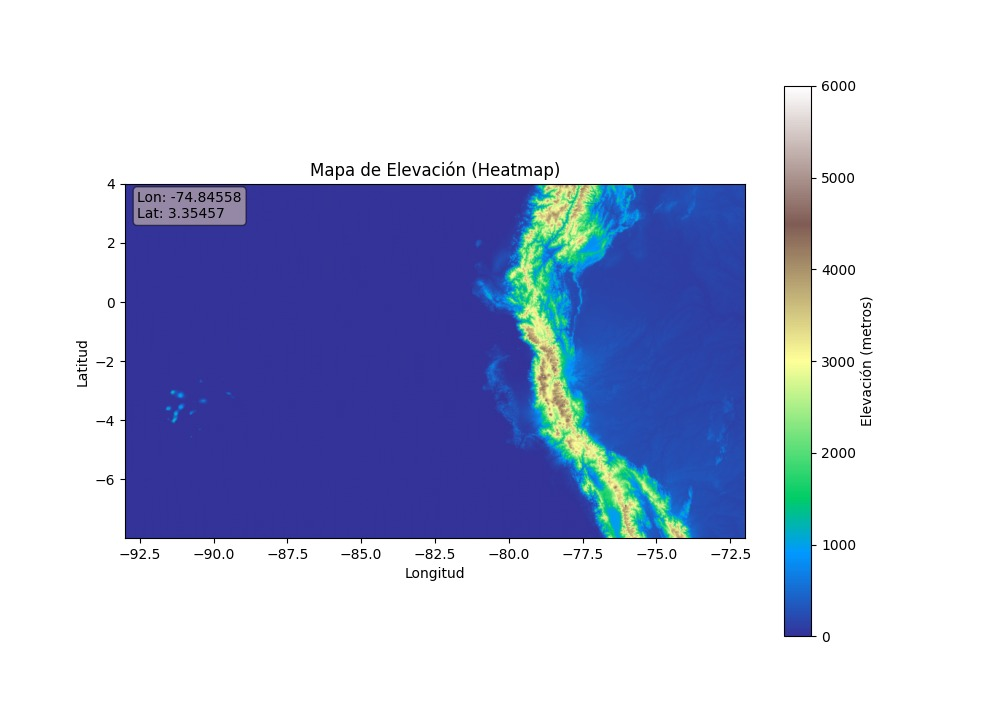
## GUI con API de Google Maps
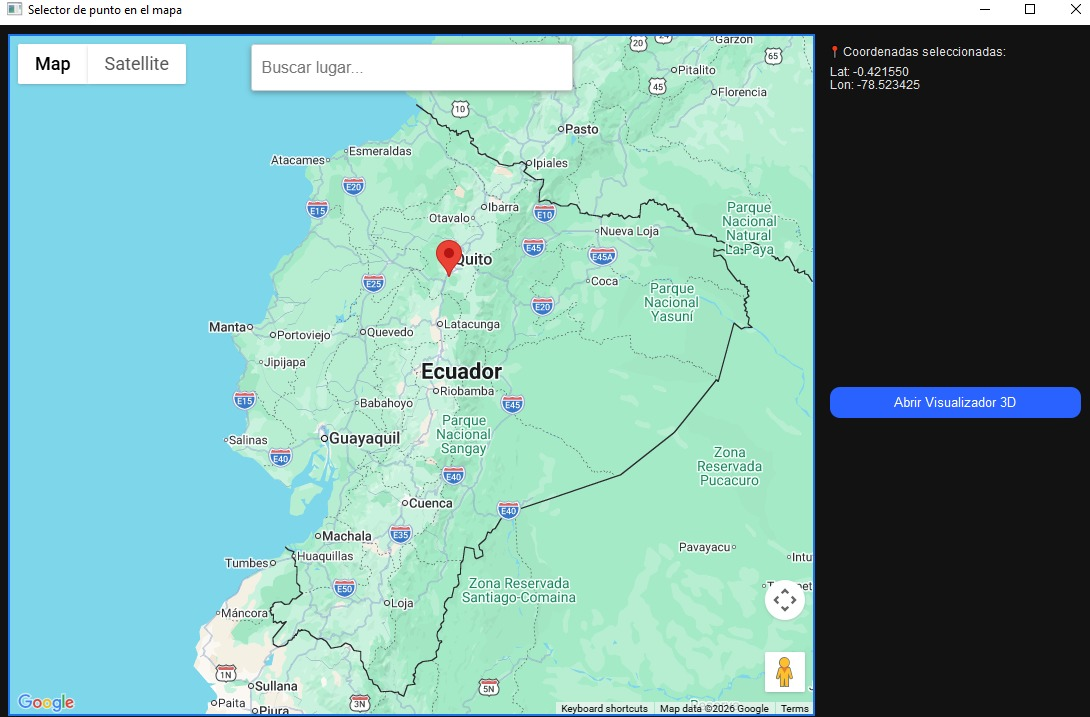
## Generación del Modelo 3D Previsualización
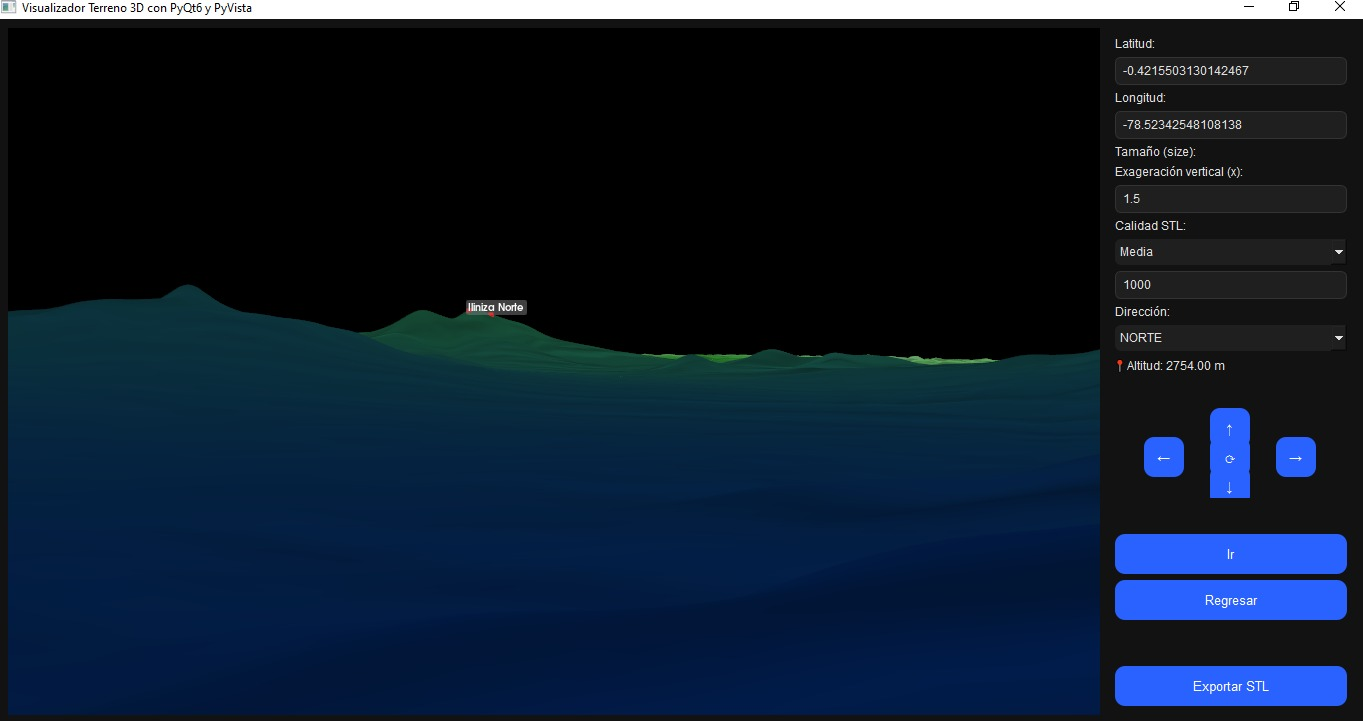
## Archivo STL exportado en Bambu Studio
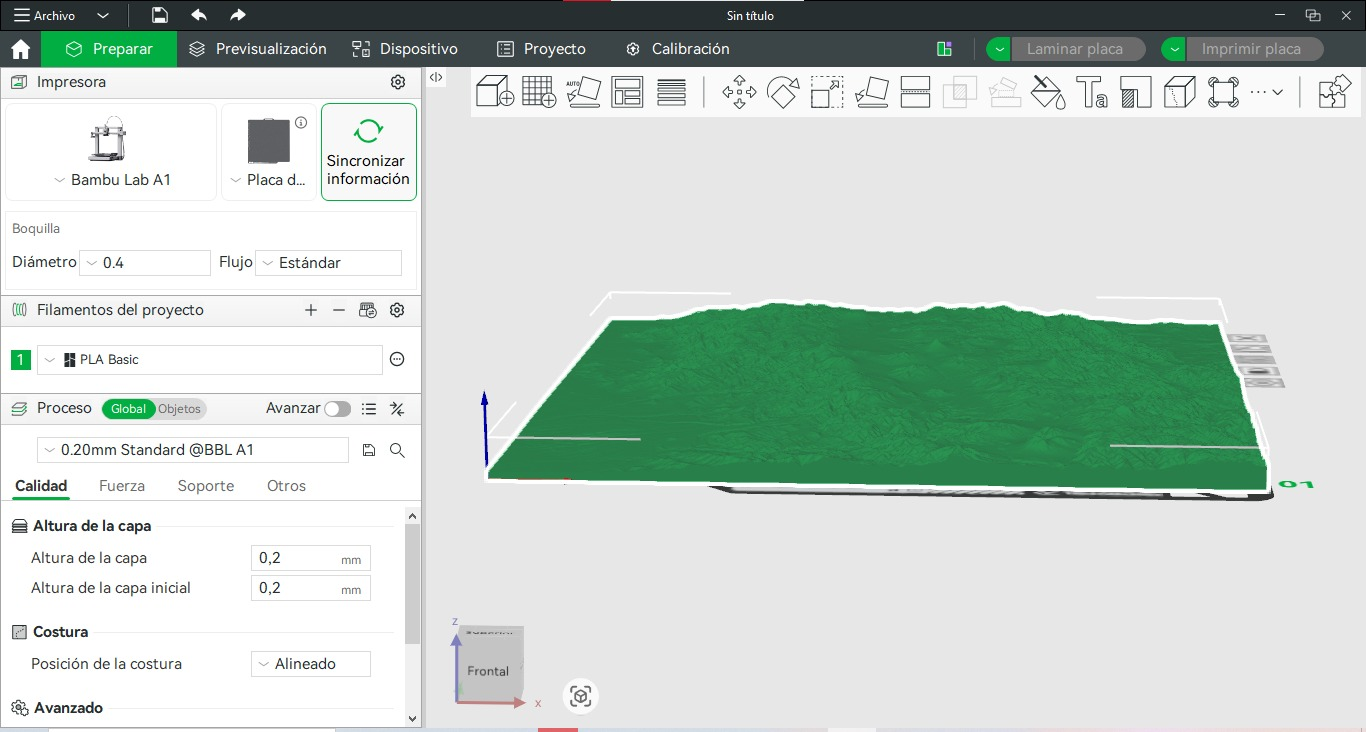

### Complejidad Computacional
- Filtro gaussiano: tiempo ~ O(N) por aplicarse separablemente; escala con número de píxeles.

- Sobel y creación de grid: O(N).

- Decimación: depende del número de triángulos m iniciales; suele comportarse superlineal (por ejemplo O(m log m)).

- Guardado STL: O(m).

En práctica, para cuadrantes grandes la decimación y la escritura son los cuellos de botella.

# 4. Conclusiones
## Hallazgos principales

- El pipeline propuesto produce modelos 3D imprimibles manteniendo una buena calidad visual si se eligen parámetros adecuados (sigma moderado, submuestreo razonable, decimación controlada).

- La separación clara entre procesamiento (Motor) y GUI facilita extendibilidad y pruebas.

- Las operaciones críticas (suavizado antes de submuestreo, build_solid, clean) son imprescindibles para garantizar archivos STL útiles para slicing.

## Dificultades y soluciones aplicadas

- Procesamiento excesivo de Datos / Limitaciones Computacionales: Utilizar formatos y librrias optimizados para el procesamiento de datos geoespaciales.
- Complejidad al integrar Interfaz Grafica: Utilizar API de google maps.
- Exportar el modelo 3D de la previsualización: Implemetar una función que reconstruya y redimensione el modelo a partir de los mismos datos que en la previsualización, pero optimizado para exportar en formato STL.

## Limitaciones

- La conversión grados→metros es aproximada; para máxima precisión geodésica debe reprojectarse a UTM.

- Decimación depende de implementaciones de VTK; resultados pueden variar con versiones.

- En hardware limitado, grandes cuadrantes requieren submuestreo o procesamiento fuera de core.

## Mejoras futuras

- Automatizar selección de parámetros (heurística basada en RAM y resolución).

- Integrar limpieza avanzada de malla (pymeshfix) y pipeline asíncrono con barra de progreso.

- Añadir pruebas automatizadas y notebooks con ejemplos sintéticos y reales.